# *CS540 PROJECT : CS CHATBOT*

-**_by TEAM F_**
- **Pavithra Govardhanan**
- **Saptarshi Chatterjee**
- **Shree Harini Ravichandran**
- **Rusha Lawande**




### Importing Packages 

In [15]:
import numpy
import random
import json
import pickle
import nltk
import tensorflow as tf
from flask import Flask,render_template
import flask_restful as restful
from flask_restful import reqparse, abort, Api, Resource
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import backend
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, Masking, TimeDistributed
from tensorflow. keras.utils import plot_model
from tensorflow.keras.models import Sequential
from nltk.stem.lancaster import LancasterStemmer

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pavig\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Reading JSON File 

In [16]:
with open("cs_dataset.json",encoding="utf-8") as data:
        contents = json.load(data)

### Pre-Processing

In [18]:
try:
    # [IMP: If you changing the json input data, delete the pickle file and try running code again]
    # Try loading already pre-processed data from the pickle file.
    with open("cache.pickle", "rb") as f:
        vocabulary, labels, training, output = pickle.load(f)

except:

    # If no stored data in pickle file, pre-process the data, and store it now.
    vocabulary = []
    labels = []
    docs_x = []
    docs_y = []

    # Extract words from the patterns, extract labels (tags)

    for intent in data["intents"]:
        for pattern in intent["patterns"]:

            tokenized_words = nltk.word_tokenize(pattern) 
            vocabulary.extend(tokenized_words) 
            docs_x.append(tokenized_words)
            docs_y.append(intent["tag"])

        if intent["tag"] not in labels:
            labels.append(intent["tag"])

    # Stem the words. This process will bring the words to its root (the main meaning)

    vocabulary = [word_stemmer.stem(w.lower()) for w in vocabulary if w != "?"]  
    vocabulary = sorted(list(set(vocabulary)))

    labels = sorted(labels)

    # Neural network doesn't understand strings at all so we need to convert our input and
    # output into a list of numbers. This is called "a bag of words" in neural network terminoloy.
    # And the process to covert string into numbers is called "One hot encoding".

    training = []
    output = []

    out_empty = [0 for _ in range(len(labels))]

    for x, doc in enumerate(docs_x):
        bag_of_words = []

        wrds = [word_stemmer.stem(w) for w in doc]

        for w in vocabulary:
            if w in wrds:
                bag_of_words.append(1)
            else:
                bag_of_words.append(0)

        output_row = out_empty[:]
        output_row[labels.index(docs_y[x])] = 1

        training.append(bag_of_words)
        output.append(output_row)

    # Convert the two lists (training input list) and (output) into numpy arrays.

    training = numpy.array(training)
    output = numpy.array(output)

    # Write the pre-processed data into the pickle file to use it subsequent time.
    with open("cache.pickle", "wb") as f:
        pickle.dump((vocabulary, labels, training, output), f)


In [19]:
print(len(vocabulary))

304


### Bag of Words 

In [20]:
def bag_of_words(user_query, vocabulary):
    bag = [0 for _ in range(len(vocabulary))]

    s_words = nltk.word_tokenize(user_query)
    s_words = [word_stemmer.stem(word.lower()) for word in s_words]

    for se in s_words:
        for i, w in enumerate(vocabulary):
            if se == w:
                bag[i] = 1

    return numpy.array(bag)


### Convolutional Neural Network(CNN) 

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding, LSTM
cnn_model = Sequential()
cnn_model.add(Embedding(304, 32, input_length=304))
cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(MaxPooling1D(pool_size = 3))
# model.add(LSTM(100))
cnn_model.add(Flatten())
cnn_model.add(Dense(50, activation='relu'))
cnn_model.add(Dense(172,activation='softmax'))
cnn_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [22]:
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 304, 32)           9728      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 300, 128)          20608     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 100, 128)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 12800)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                640050    
_________________________________________________________________
dense_3 (Dense)              (None, 172)               8772      
Total params: 679,158
Trainable params: 679,158
Non-trainable params: 0
________________________________________________

In [30]:
cnn=cnn_model.fit(training, output, epochs=100,verbose = 2, batch_size=16)

Epoch 1/100
428/428 - 0s - loss: 5.9308e-04 - acc: 0.9996
Epoch 2/100
428/428 - 0s - loss: 6.1889e-04 - acc: 0.9995
Epoch 3/100
428/428 - 0s - loss: 5.6644e-04 - acc: 0.9996
Epoch 4/100
428/428 - 0s - loss: 5.6755e-04 - acc: 0.9996
Epoch 5/100
428/428 - 0s - loss: 5.5843e-04 - acc: 0.9995
Epoch 6/100
428/428 - 0s - loss: 5.8946e-04 - acc: 0.9995
Epoch 7/100
428/428 - 0s - loss: 5.7991e-04 - acc: 0.9996
Epoch 8/100
428/428 - 0s - loss: 5.8405e-04 - acc: 0.9995
Epoch 9/100
428/428 - 0s - loss: 5.7422e-04 - acc: 0.9996
Epoch 10/100
428/428 - 0s - loss: 5.6209e-04 - acc: 0.9995
Epoch 11/100
428/428 - 0s - loss: 5.9398e-04 - acc: 0.9995
Epoch 12/100
428/428 - 0s - loss: 5.6222e-04 - acc: 0.9995
Epoch 13/100
428/428 - 0s - loss: 5.6731e-04 - acc: 0.9996
Epoch 14/100
428/428 - 0s - loss: 5.4941e-04 - acc: 0.9995
Epoch 15/100
428/428 - 0s - loss: 5.6645e-04 - acc: 0.9996
Epoch 16/100
428/428 - 0s - loss: 6.0402e-04 - acc: 0.9995
Epoch 17/100
428/428 - 0s - loss: 5.7216e-04 - acc: 0.9995
Epoch 

In [45]:
cnn_model.save('model_cs_cnn.h5')
print("Model saved successfully...")

Model saved successfully...


### Accuracy (CNN) 

In [32]:


scores = cnn_model.evaluate(training, output, verbose=1)
print("Accuracy:", scores[1])

428/428 [==============================] - 0s 149us/sample - loss: 5.0551e-04 - acc: 0.9996
Accuracy: 0.99964684


### Graph results of CNN 

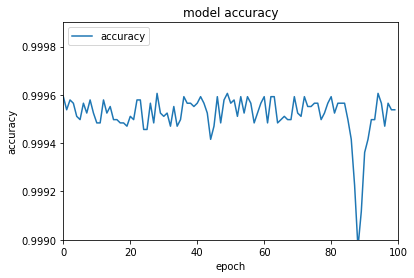

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(cnn.history['acc'])
plt.title('model accuracy')
plt.ylim(0.9990,0.9999)
plt.xlim(0,100)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy'], loc='upper left')
plt.show()

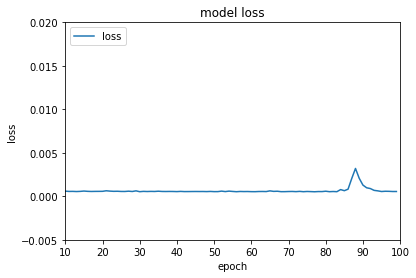

In [40]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(cnn.history['loss'])
plt.title('model loss')
plt.ylim(-0.005,0.02)
plt.xlim(10,100)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss'], loc='upper left')
plt.show()

### Recurrent Neural Network (RNN)

In [41]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, LSTM,SimpleRNN
rnn_model = Sequential()
rnn_model.add(Embedding(304, 32, input_length=304))
rnn_model.add(SimpleRNN(128, activation='relu', return_sequences=True))
rnn_model.add(Flatten())
rnn_model.add(Dense(50, activation='relu'))
rnn_model.add(Dense(172,activation='softmax'))
rnn_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Using TensorFlow backend.


In [42]:
rnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 304, 32)           9728      
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 304, 128)          20608     
_________________________________________________________________
flatten_1 (Flatten)          (None, 38912)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                1945650   
_________________________________________________________________
dense_2 (Dense)              (None, 172)               8772      
Total params: 1,984,758
Trainable params: 1,984,758
Non-trainable params: 0
_________________________________________________________________


In [44]:
rnn=rnn_model.fit(training, output, epochs=100,verbose = 2, batch_size=16,validation_split=0.1)


Train on 385 samples, validate on 43 samples
Epoch 1/100
 - 2s - loss: 5.1600 - accuracy: 0.0130 - val_loss: 5.2098 - val_accuracy: 0.0000e+00
Epoch 2/100
 - 2s - loss: 5.0602 - accuracy: 0.0078 - val_loss: 5.7191 - val_accuracy: 0.0000e+00
Epoch 3/100
 - 2s - loss: 4.7020 - accuracy: 0.0701 - val_loss: 6.6595 - val_accuracy: 0.0000e+00
Epoch 4/100
 - 2s - loss: 3.6596 - accuracy: 0.2571 - val_loss: 9.9189 - val_accuracy: 0.0000e+00
Epoch 5/100
 - 2s - loss: 2.4401 - accuracy: 0.4494 - val_loss: 13.6074 - val_accuracy: 0.0233
Epoch 6/100
 - 2s - loss: 1.5037 - accuracy: 0.6208 - val_loss: 20.1716 - val_accuracy: 0.0465
Epoch 7/100
 - 2s - loss: 1.0062 - accuracy: 0.7558 - val_loss: 21.3136 - val_accuracy: 0.0465
Epoch 8/100
 - 2s - loss: 0.6611 - accuracy: 0.8208 - val_loss: 28.7073 - val_accuracy: 0.0465
Epoch 9/100
 - 2s - loss: 0.4992 - accuracy: 0.8779 - val_loss: 26.4922 - val_accuracy: 0.0465
Epoch 10/100
 - 2s - loss: 0.3457 - accuracy: 0.9039 - val_loss: 33.1075 - val_accuracy

Epoch 84/100
 - 2s - loss: 0.0560 - accuracy: 0.9481 - val_loss: 34.6715 - val_accuracy: 0.0465
Epoch 85/100
 - 2s - loss: 0.0532 - accuracy: 0.9429 - val_loss: 35.1030 - val_accuracy: 0.0465
Epoch 86/100
 - 2s - loss: 0.0529 - accuracy: 0.9610 - val_loss: 35.6363 - val_accuracy: 0.0465
Epoch 87/100
 - 2s - loss: 0.0523 - accuracy: 0.9532 - val_loss: 36.3590 - val_accuracy: 0.0465
Epoch 88/100
 - 2s - loss: 0.0539 - accuracy: 0.9558 - val_loss: 36.0615 - val_accuracy: 0.0465
Epoch 89/100
 - 2s - loss: 0.0569 - accuracy: 0.9558 - val_loss: 35.2247 - val_accuracy: 0.0465
Epoch 90/100
 - 2s - loss: 0.0552 - accuracy: 0.9584 - val_loss: 34.7313 - val_accuracy: 0.0465
Epoch 91/100
 - 2s - loss: 0.0522 - accuracy: 0.9558 - val_loss: 34.8928 - val_accuracy: 0.0465
Epoch 92/100
 - 2s - loss: 0.0611 - accuracy: 0.9584 - val_loss: 33.5334 - val_accuracy: 0.0465
Epoch 93/100
 - 2s - loss: 0.0537 - accuracy: 0.9610 - val_loss: 33.2570 - val_accuracy: 0.0465
Epoch 94/100
 - 2s - loss: 0.0699 - accu

### Accuracy (RNN) 

In [47]:
rnn_model.save('model_cs_rnn.h5')
print("Model saved successfully...")

scores = rnn_model.evaluate(training, output, verbose=1)
print("Accuracy:", scores[1])

Model saved successfully...
428/428 [==============================] - 0s 745us/step
Accuracy: 0.8644859790802002


### Graph results of RNN 

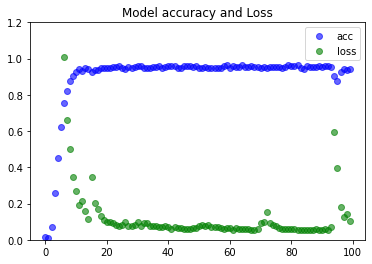

In [51]:
%matplotlib inline
import matplotlib.pyplot as plt

acc=rnn.history['accuracy']
loss=rnn.history['loss']


epochs=range(len(acc))

plt.plot(epochs,acc,'bo', alpha = 0.6, label='acc')
plt.ylim(0,1.2)
plt.plot(epochs, loss,'go',alpha=0.6, label='loss')
plt.title('Model accuracy and Loss')
plt.legend()